# Homework 1 - Wine Classification

Artificial Intelligence and Machine Learning  
Loparco Enrico - s261072

## Table of Contents
* [Load data](#Load-data)
* [K-NN](#K-NN)
    + [Parameter tuning](#parameter-tuning-knn)
    + [Model evaluation](#model-evaluation-knn)
* [Linear SVM](#Linear-SVM)
    + [Parameter tuning](#parameter-tuning-svm)
    + [Model evaluation](#model-evaluation-svm)
* [Kernel SVM](#Kernel-SVM)
    + [Parameter tuning](#parameter-tuning-ksvm)
    + [Model evaluation](#model-evaluation-ksvm)
* [Kernel SVM - Grid Search](#Kernel-SVM---Grid-search)
    + [Parameter tuning](#parameter-tuning-grid-svm)
    + [Model evaluation](#model-evaluation-grid-svm)
    + [Parameter tuning with k-fold validation](#parameter-tuning-svm-validation)
    + [Model evaluation with k-fold validation](#model-evaluation-svm-validation)
* [Extra](#Extra)
    + [Comparison between KNN and SVM](#comparison-between-KNN-and-SVM)
    + [Another pair of attributes](#another-pair-of-attributes)

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from plot import *

# setup seed for the whole notebook
SEED = 42

In [2]:
# print dataset description
data = load_wine()
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

## Load data

1. Load Wine dataset
2. Select the first two attributes for a 2D representation of the image.
3. Randomly split data into train, validation and test sets in proportion 5:2:3

In [3]:
# 1. load dataset
features_raw, target = data.data, data.target

# 2. select only the fisrt two attributes
features = features_raw[:,:2]
print(f"features shape: {features.shape}\ntarget shape: {target.shape}")

feature1, feature2 = data.feature_names[0], data.feature_names[1]
print(f"feature 1 name: {feature1}\nfeature 2 name: {feature2}")

features shape: (178, 2)
target shape: (178,)
feature 1 name: alcohol
feature 2 name: malic_acid


In [4]:
# 3. Split data into train, validation and test sets in proportion 5:2:3
X, X_test, y, y_test = train_test_split(features, target, test_size=0.3, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=2/7, random_state=SEED)

In [5]:
# standardization: remove this block to compare results with and without standardization
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## K-NN

### Parameter tuning <a name="parameter-tuning-knn"></a>

4.
For K = [1,3, 5,7]:  
* Apply K-Nearest Neighbors  
* Plot the data and the decision boundaries  
* Evaluate the method on the validation set

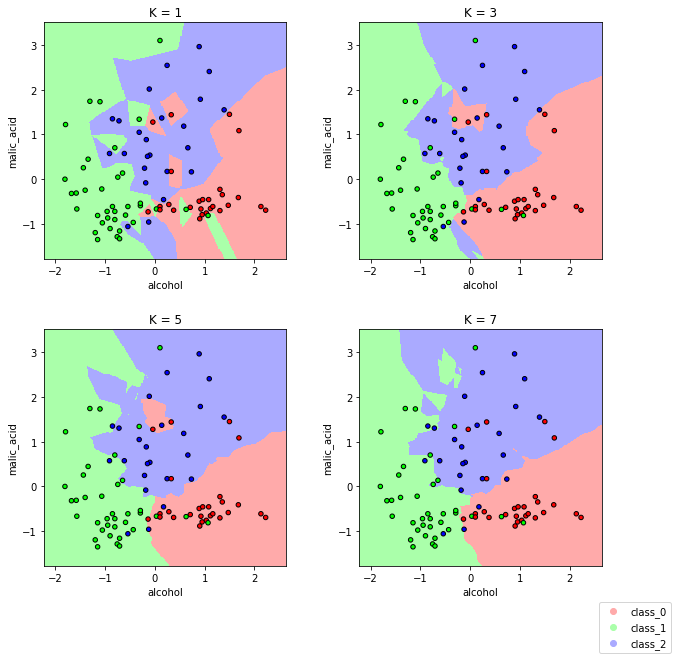

In [6]:
i = 0
k_range = [1,3,5,7]
scores = []
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
print_scatter_legend(fig, data.target_names, ['#FFAAAA', '#AAFFAA', '#AAAAFF'])

for k in k_range:
    # train model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) 
    
    # make prediction on validation set and store accuracy
    y_pred = knn.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))
    
    # visualize boundaries
    curr_ax = axes.ravel()[i]
    plot_data_and_boundaries(X_train, y_train, knn, curr_ax, feature1, feature2, "K = " + str(k))

    i += 1

### Model evaluation <a name="model-evaluation-knn"></a>

5. Plot a graph showing how the accuracy on the validation set varies when changing K



In [7]:
d = {'k': k_range, 'accuracy': scores}
df = pd.DataFrame(data=d)

df.set_index('k').transpose()

k,1,3,5,7
accuracy,0.75,0.861111,0.916667,0.888889


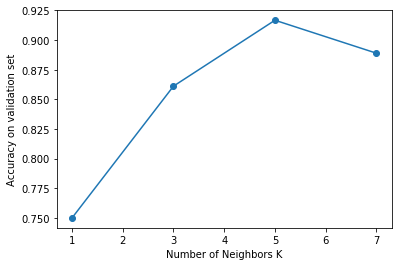

In [8]:
plt.plot([1,3,5,7], scores, marker='o')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy on validation set');

6. How do the boundaries change? Why?  
   Increasing K the classifier is more resilient to noise and generalization improves.

7. Use the best value of K and evaluate the model on the test set. How well does it works?

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.7592592592592593


## Linear SVM

### Parameter tuning <a name="parameter-tuning-svm"></a>

8.
For C = [0.001, 0.01, 0.1, 1, 10, 100,1000]:  
* Train a linear SVM on the training set 
* Plot the data and the decision boundaries  
* Evaluate the method on the validation set

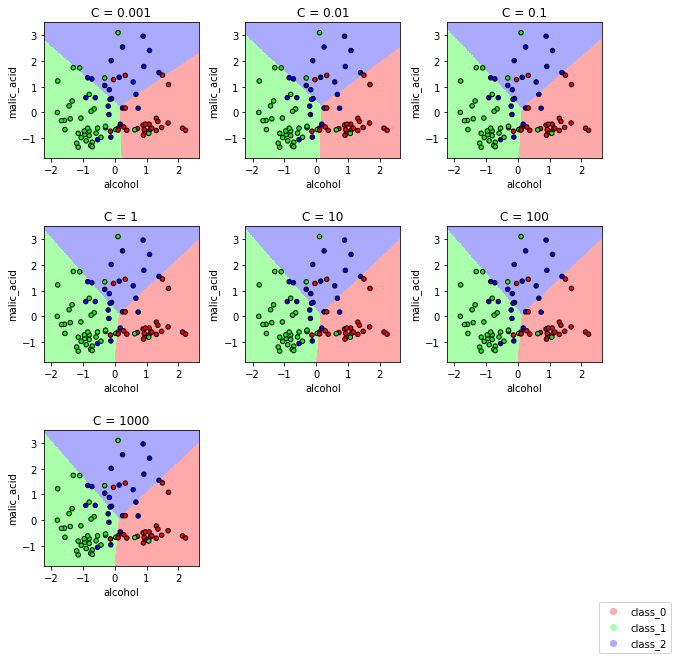

In [10]:
i = 0
C_range = [0.001, 0.01, 0.1, 1, 10, 100,1000]
scores = []
fig, axes = plt.subplots(3, 3, figsize=(10,10))
# delete empty axes
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

fig.subplots_adjust(wspace=0.3, hspace=0.5)
print_scatter_legend(fig, data.target_names, ['#FFAAAA', '#AAFFAA', '#AAAAFF'])

for C in C_range:
    # train model
    svm = LinearSVC(C=C, random_state=SEED, max_iter=1e6)
    svm.fit(X_train, y_train)
    
    # make prediction on validation set and store accuracy
    y_pred = svm.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))

    # visualize boundaries
    curr_ax = axes.ravel()[i]
    plot_data_and_boundaries(X_train, y_train, svm, curr_ax, feature1, feature2, "C = " + str(C))

    i += 1   

### Model evaluation <a name="model-evaluation-svm"></a>

9. Plot a graph showing how the accuracy on the validation set varies when changing C

In [11]:
d = {'C': C_range, 'accuracy': scores}
df = pd.DataFrame(data=d)

df.set_index('C').transpose()

C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
accuracy,0.805556,0.805556,0.833333,0.833333,0.833333,0.833333,0.833333


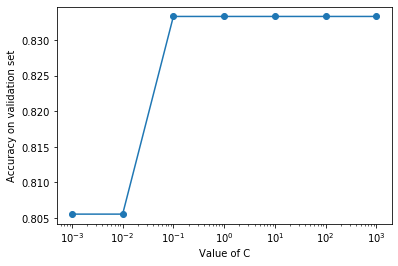

In [12]:
plt.plot(C_range, scores, marker='o')
plt.xlabel('Value of C')
plt.ylabel('Accuracy on validation set')
plt.xscale('log')

10. How the boundaries change? Why?  
    Increasing C allow "softer" margins, resulting in a classifier more resilient to noise and with better generalization.

11. Use the best value of C and evaluate the model on the test set.
How well does it works?

In [13]:
svm = LinearSVC(C=10, random_state=SEED, max_iter=1e6)
svm.fit(X, y)  
y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.7592592592592593


## Kernel SVM

### Parameter tuning <a name="parameter-tuning-ksvm"></a>

12. Repeat point 8. (train, plot, etc..), but this time use an RBF kernel

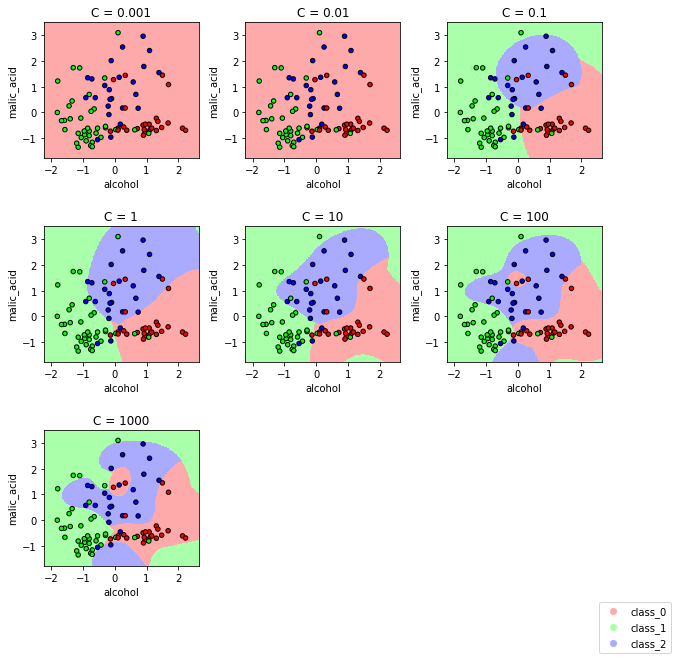

In [14]:
i = 0
C_range = [0.001, 0.01, 0.1, 1, 10, 100,1000]
scores = []
fig, axes = plt.subplots(3, 3, figsize=(10,10))
# delete empty axes
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

fig.subplots_adjust(wspace=0.3, hspace=0.5)
print_scatter_legend(fig, data.target_names, ['#FFAAAA', '#AAFFAA', '#AAAAFF'])

for C in C_range:
    # train model
    svm = SVC(C=C, kernel='rbf', gamma='scale', random_state=SEED)
    svm.fit(X_train, y_train)
    
    # make prediction on validation set and store accuracy
    y_pred = svm.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))

    # visualize boundaries
    curr_ax = axes.ravel()[i]
    plot_data_and_boundaries(X_train, y_train, svm, curr_ax, feature1, feature2, "C = " + str(C))

    i += 1

### Model evaluation <a name="model-evaluation-ksvm"></a>

12. Repeat point 8. (train, plot, etc..), but this time use an RBF kernel

In [15]:
d = {'C': C_range, 'accuracy': scores}
df = pd.DataFrame(data=d)

df.set_index('C').transpose()

C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
accuracy,0.361111,0.361111,0.861111,0.861111,0.861111,0.861111,0.833333


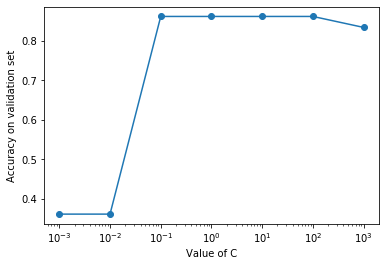

In [16]:
plt.plot(C_range, scores, marker='o')
plt.xlabel('Value of C')
plt.ylabel('Accuracy on validation set')
plt.xscale('log')

13. Evaluate the best C on the test set


In [17]:
svm = SVC(C=10, kernel='rbf', gamma='scale', random_state=SEED)
svm.fit(X, y)

# formula for gamma='scale' from documentation
print(f"gamma='scale': {1 / (2 * X.var())}")

y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

gamma='scale': 0.5
Accuracy on test set: 0.8333333333333334


14. Are there any differences compared to the linear kernel? How are the boundaries different?  
    As expected, the boundaries are non-linear.


## Kernel SVM - Grid search

### Parameter tuning <a name="parameter-tuning-grid-svm"></a>

15. Perform a grid search of the best parameters for an RBF kernel: we will
 now tune both gamma and C at the same time. Select an appropriate
 range for both parameters. Train the model and score it on the validation
 set. Evaluate the best parameters on the test set. Plot the decision 
 boundaries.

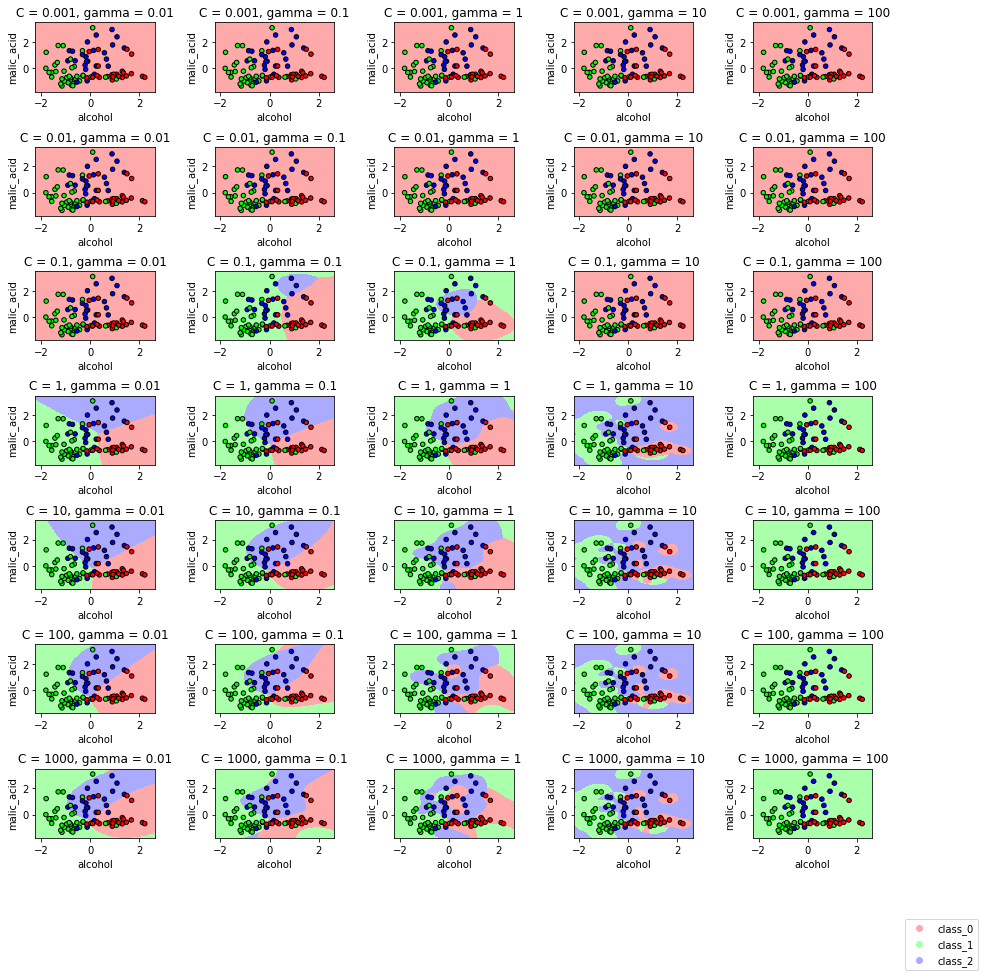

In [18]:
i = 0
C_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_range = [0.01, 0.1, 1, 10, 100]
scores = {}
fig, axes = plt.subplots(7, 5, figsize=(15,15))

fig.subplots_adjust(wspace=0.5, hspace=0.8)
print_scatter_legend(fig, data.target_names, ['#FFAAAA', '#AAFFAA', '#AAAAFF'])

for C in C_range:
    scores_row = []
    for gamma in gamma_range:
        # train model
        svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=SEED)
        svm.fit(X_train, y_train)

        # make prediction on validation set and store accuracy
        y_pred = svm.predict(X_val)      
        scores_row.append(metrics.accuracy_score(y_val, y_pred))

        # visualize boundaries
        curr_ax = axes.ravel()[i]
        plot_data_and_boundaries(X_train, y_train, svm, curr_ax, feature1, feature2, "C = " + str(C) + ", gamma = " + str(gamma))

        i += 1
    scores[C] = scores_row

### Model evaluation <a name="model-evaluation-grid-svm"></a>

In [19]:
def highlight_max(val):
    color = 'yellow' if val == max_value else ''
    return 'background-color: %s' % color
    
grid = pd.DataFrame(data=scores, index=gamma_range)
grid.columns.name = 'gamma \ C'
max_value = grid.values.max()
display(grid.style.applymap(highlight_max))

gamma \ C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
0.01,0.361111,0.361111,0.361111,0.75,0.833333,0.861111,0.805556
0.1,0.361111,0.361111,0.583333,0.888889,0.888889,0.861111,0.861111
1.0,0.361111,0.361111,0.805556,0.861111,0.861111,0.805556,0.666667
10.0,0.361111,0.361111,0.361111,0.805556,0.694444,0.638889,0.638889
100.0,0.361111,0.361111,0.361111,0.611111,0.638889,0.638889,0.638889


In [20]:
svm = SVC(C=10, gamma=0.1, kernel='rbf', random_state=SEED)
svm.fit(X, y)

y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.8148148148148148


16. Merge the training and validation split. You should now have 70% training and 30% test data.

### Parameter tuning with k-fold validation <a name="parameter-tuning-svm-validation"></a>

17. Repeat the grid search for gamma and C but this time perform 5-fold validation.


In [21]:
# perform 5-fold validation using GridSearchCV
parameters = {'C':C_range, 'gamma':gamma_range}
svm = SVC(kernel='rbf', random_state=SEED)

grid = GridSearchCV(svm, parameters, cv=5, iid=False)
grid.fit(X, y)

print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}\n")
print('Complete list of results')
for mean_test, param in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
    print(f"{param} test score: {mean_test}")

The best parameters are {'C': 1000, 'gamma': 0.01} with a score of 0.8303333333333335

Complete list of results
{'C': 0.001, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 0.1} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 1} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 10} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 100} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 0.1} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 1} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 10} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 100} test score: 0.4033333333333333
{'C': 0.1, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.1, 'gamma': 0.1} test score: 0.7256666666666667
{'C': 0.1, 'gamma': 1} test score: 0.7906666666666667
{'C': 0.1, 'gamma': 10} test score: 0.41966666666666674
{'C': 0.1, 'gamma': 100} test score: 0.4033333333333333
{'C': 1, 'gamma': 0.01} test score: 0.

In [22]:
# perform 5-fold validation without using GridSearchCV (similar results wrt GridSearchCV,
# even if in this case the k-fold validation is not stratified)

# for C in C_range:
#     for gamma in gamma_range:
#         svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=SEED)
# 
#         # shuffle=False result is different from before
#         kfold = KFold(n_splits=5, random_state=SEED, shuffle=False)
#         scores = []
#         for train_indices, test_indices in kfold.split(X):
#             X_kf_train, X_kf_test = X[train_indices], X[test_indices]
#             y_kf_train, y_kf_test = y[train_indices], y[test_indices]
#             svm.fit(X_kf_train, y_kf_train)
# 
#             y_pred = svm.predict(X_kf_test)
#             scores.append(metrics.accuracy_score(y_kf_test, y_pred))
#         print("(C={0}, gamma={1}) accuracy={2}".format(C, gamma, np.mean(scores)))

### Model evaluation with k-fold validation <a name="model-evaluation-svm-validation"></a>

18. Evaluate the parameters on the test set. Is the final score different? Why?

In [24]:
# use the best combination of parameters
svm = grid.best_estimator_
svm.fit(X, y)

y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.7777777777777778


## Extra

### Comparison between KNN and SVM <a name="comparison-between-KNN-and-SVM"></a>

19. Discuss the difference between KNN and SVM

|| KNN | SVM |
|:-:|:---:|:---:|
|intuition| close/similar samples have the same label | learn from most challenging points to separate (support vectors) |
|problem type | classification (variants for regression)| classification (variants for regression)|
|linear/non-linear| non-linear classifier | linear classifier (non-linear using kernel trick) || focus on all points / k-nearest points | focus on points that are the most difficult to separate
|training| fast, no real training | slow, iterate over all the samples to learn the model |
|prediction| slow, iterate over all the samples (does not scale) | fast, apply the model learned |
|space complexity| need to store all samples | only support vectors are relevant, no need to keep the whole training set |
|multi-class| yes | yes, using One-vs-One or One-vs-All approaches |
| main hyper-parameter| K (number of neighbors) | C (soft-margin parameter, regularization) |
| other decisions/parameters to choose | distance metric | kernel to use and kernel parameters (gamma if RBF) |
|curse of dimensionality| is an issue | not affected |
|resiliance to outliers| sensitive to outliers (less sensitive with larger k) | more robust with larger C ("softer" margins)

### Another pair of attributes <a name="another-pair-of-attributes"></a>

20. Try also with different pairs of attributes

In [25]:
# 1. load dataset
features_raw, target = data.data, data.target

# 2. color intensity and hue attributes
color_intensity_index = 9
hue_index = 10

features = features_raw[:,[color_intensity_index, hue_index]]
feature1, feature2 = data.feature_names[color_intensity_index], data.feature_names[hue_index]
print(f"feature 1 name: {feature1}\nfeature 2 name: {feature2}")

# 3. Split data into train, validation and test sets in proportion 5:2:3
X, X_test, y, y_test = train_test_split(features, target, test_size=0.3, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=2/7, random_state=SEED)

# standardization: remove this block to compare results with and without standardization
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

feature 1 name: color_intensity
feature 2 name: hue


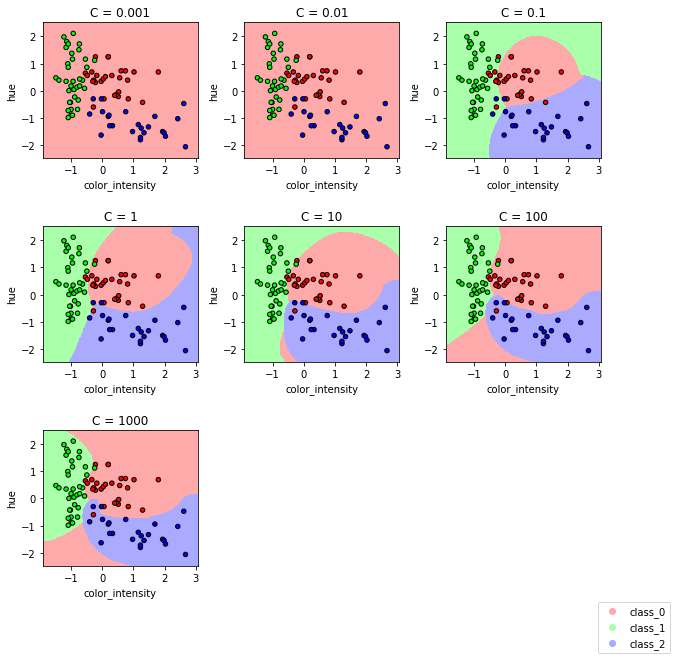

In [26]:
i = 0
C_range = [0.001, 0.01, 0.1, 1, 10, 100,1000]
scores = []
fig, axes = plt.subplots(3, 3, figsize=(10,10))
# delete empty axes
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

fig.subplots_adjust(wspace=0.3, hspace=0.5)
print_scatter_legend(fig, data.target_names, ['#FFAAAA', '#AAFFAA', '#AAAAFF'])

for C in C_range:
    # train model
    svm = SVC(C=C, kernel='rbf', gamma='scale', random_state=SEED)
    svm.fit(X_train, y_train)
    
    # make prediction on validation set and store accuracy
    y_pred = svm.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))

    # visualize boundaries
    curr_ax = axes.ravel()[i]
    plot_data_and_boundaries(X_train, y_train, svm, curr_ax, feature1, feature2, "C = " + str(C))

    i += 1

In [27]:
d = {'C': C_range, 'accuracy': scores}
df = pd.DataFrame(data=d)

df.set_index('C').transpose()

C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
accuracy,0.361111,0.361111,0.777778,0.75,0.777778,0.75,0.75


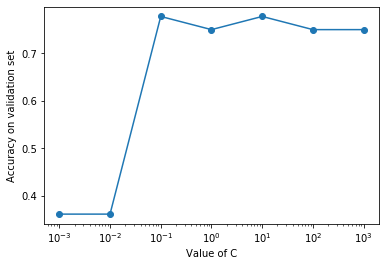

In [28]:
plt.plot(C_range, scores, marker='o')
plt.xlabel('Value of C')
plt.ylabel('Accuracy on validation set')
plt.xscale('log')

In [29]:
svm = SVC(C=0.1, kernel='rbf', gamma='scale', random_state=SEED)
svm.fit(X, y)

print(f"gamma='scale': {1 / (2 * X.var())}")

y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

gamma='scale': 0.4999999999999999
Accuracy on test set: 0.7962962962962963


In [30]:
# perform 5-fold validation using GridSearchCV
C_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_range = [0.01, 0.1, 1, 10, 100]
parameters = {'C':C_range, 'gamma':gamma_range}
svm = SVC(kernel='rbf', random_state=SEED)

grid = GridSearchCV(svm, parameters, cv=5, iid=False)
grid.fit(X, y)

print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}\n")
print('Complete list of results')
for mean_test, param in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
    print(f"{param} test score: {mean_test}")

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.8716666666666667

Complete list of results
{'C': 0.001, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 0.1} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 1} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 10} test score: 0.4033333333333333
{'C': 0.001, 'gamma': 100} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 0.1} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 1} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 10} test score: 0.4033333333333333
{'C': 0.01, 'gamma': 100} test score: 0.4033333333333333
{'C': 0.1, 'gamma': 0.01} test score: 0.4033333333333333
{'C': 0.1, 'gamma': 0.1} test score: 0.6456666666666668
{'C': 0.1, 'gamma': 1} test score: 0.8473333333333333
{'C': 0.1, 'gamma': 10} test score: 0.4033333333333333
{'C': 0.1, 'gamma': 100} test score: 0.4033333333333333
{'C': 1, 'gamma': 0.01} test score: 0.6859999

In [31]:
# use the best combination of parameters
svm = grid.best_estimator_
svm.fit(X, y)

y_pred = svm.predict(X_test)
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.8333333333333334
